In this notebook, I couple a neural network to a wave equation. Linearized analysis shows that the most unstable mode for large wave-lengths has an e-tupling time of around 10 days and a phase speed of 5 m/s. This seems slow compared to realistic wave speeds in the atmosphere, perhaps because the fastest dry gravity wave moves at around 30 m/s about this base state (see the [last notebook](https://atmos.washington.edu/~nbren12/reports/uwnet/notebooks/2019-04-16-Wave-equation-analysis-no-source.html) for more details). This propagating mode has a tilted vertical structure reminiscent of realistic CCWs, and those of Kuang. Unlike Kuang, this propagating instability has a high wave-number cutoff. However, the standing instability does not.

In [1]:
%matplotlib inline

from uwnet.wave import get_wave_from_training_data, model_plus_damping
import torch
import matplotlib.pyplot as plt
import numpy as np

from uwnet import thermo

/Users/noah/anaconda/envs/uwnet/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/noah/anaconda/envs/uwnet/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Load data, compute mean, and couple it to a wave spectruum

In [2]:
model = torch.load("../models/268/5.pkl")
model = model_plus_damping(model, d0=1/5/86400)

wave_no_src = get_wave_from_training_data()
wave = get_wave_from_training_data(src=model)

/Users/noah/anaconda/envs/uwnet/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/noah/anaconda/envs/uwnet/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'uwnet.normalization.Scaler' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/noah/anaconda/envs/uwnet/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.container.ParameterDict' has changed. you can retrieve the or

# Phase speed

/Users/noah/workspace/research/uwnet/uwnet/wave.py:232: RuntimeWarning: divide by zero encountered in true_divide
  eigs = np.linalg.eigvals(As) / k[:, np.newaxis]
/Users/noah/workspace/research/uwnet/uwnet/wave.py:232: RuntimeWarning: invalid value encountered in true_divide
  eigs = np.linalg.eigvals(As) / k[:, np.newaxis]


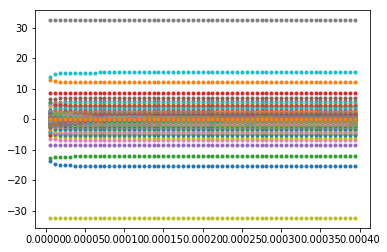

In [3]:
wave.plot_eigs_spectrum()

# Growth rates

Text(0.5, 0, 'k (1/km)')

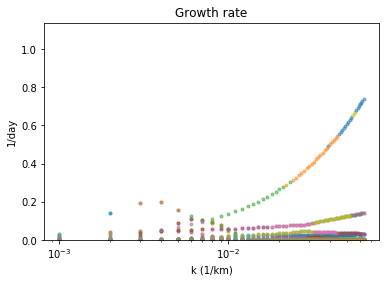

In [4]:
k, As = wave.matrices()

lam = np.linalg.eigvals(As)

plt.semilogx(k*1e3, lam.real*86400, '.', alpha=.5);
plt.ylim(bottom=0)
plt.title("Growth rate")
plt.ylabel("1/day")
plt.xlabel("k (1/km)")

The instability which grows with $k$ is 

# Structure of mode
The earliest peak instability rate is a propagating instability. Let's extract it for one wavenumber:

In [5]:
print("Wavelength", 2*np.pi/k[5]/1e3, "km")

Wavelength 1256.637061435917 km


In [6]:
l, r = wave.get_eigen_pair(k=k[5])
i = l.real.argmax()
lam = l[i]
ri = r[:, i]
wave.field_order

('w', 's', 'q')

In [7]:
struct = dict(zip(wave.field_order, np.split(ri, 3)))

In [8]:
def plot_struct(w):
    plt.plot(w.real)
    plt.plot(w.imag)
    
def plot_struct_2d(w, n=256, **kwargs):
    phase = 2*np.pi * np.r_[:n]/n
    phi = np.exp(1j * phase)[:,None]
    real_component = (w * phi).real
    z = wave.center_heights.detach().numpy()
    plt.contourf(phase, z, real_component.T, **kwargs)
    plt.xlabel("phase")
    plt.ylabel("z (m)")

## Phase speed

In [9]:
c = - lam.imag/k[5]
sigma = lam.real*86400
print("Phase speed", c, "m/s")
print("Growth rate", sigma, "1/day")

Phase speed -5.53213758394122 m/s
Growth rate 0.15556885300611611 1/day


## Visualize one oscillation

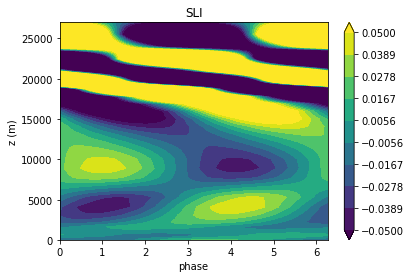

In [10]:
plot_struct_2d(struct['s'], levels=np.linspace(-.05, .05, 10), extend='both')
plt.title("SLI")
plt.colorbar()

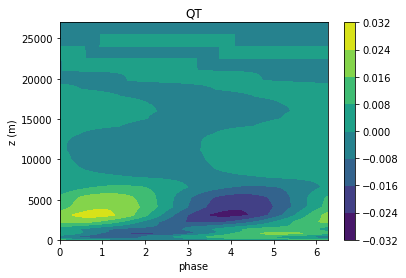

In [11]:
plot_struct_2d(struct['q'])
plt.title("QT")
plt.colorbar()

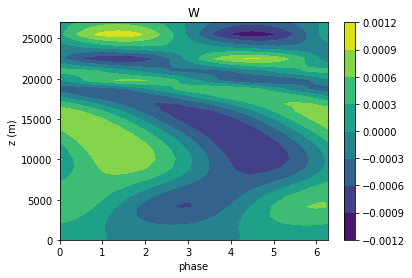

In [12]:
plot_struct_2d(struct['w'])
plt.title("W")
plt.colorbar()